## 0. Download dataset
**Note:** If you can't download using gdown due to limited number of downloads, please download it manually and upload it to your drive, then copy it from the drive to colab.
```python
from google.colab import drive

drive.mount('/content/drive')
!cp /path/to/dataset/on/your/drive .
```

In [ ]:
!gdown --id 178YSDYmlRh54IcxStgYA3UyKFRM9-3DO

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=178YSDYmlRh54IcxStgYA3UyKFRM9-3DO
To: /content/dataset.zip
100% 2.35M/2.35M [00:00<00:00, 19.5MB/s]


In [ ]:
!unzip dataset.zip

Archive:  dataset.zip
   creating: dataset/
  inflating: dataset/weatherHistory.csv  


In [ ]:
!pip install unidecode

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 9.3 MB/s eta 0:00:00


## 1. Import libraries

In [1]:
import torch
import torch.nn as nn

seed = 1
torch.manual_seed(seed)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader

## 2. Read dataset

In [2]:
dataset_filepath = 'dataset/weatherHistory.csv'
df = pd.read_csv(dataset_filepath)

In [3]:
univariate_df = df['Temperature (C)']
univariate_df.index = df['Formatted Date']

In [4]:
univariate_df

Formatted Date
2006-04-01 00:00:00.000 +0200     9.472222
2006-04-01 01:00:00.000 +0200     9.355556
2006-04-01 02:00:00.000 +0200     9.377778
2006-04-01 03:00:00.000 +0200     8.288889
2006-04-01 04:00:00.000 +0200     8.755556
                                   ...    
2016-09-09 19:00:00.000 +0200    26.016667
2016-09-09 20:00:00.000 +0200    24.583333
2016-09-09 21:00:00.000 +0200    22.038889
2016-09-09 22:00:00.000 +0200    21.522222
2016-09-09 23:00:00.000 +0200    20.438889
Name: Temperature (C), Length: 96453, dtype: float64

## 3. Data preprocessing

In [5]:
input_size = 6
label_size = 1
offset = 1

def slicing_window(df, df_start_idx, df_end_idx, input_size, label_size, offset):
    features = []
    labels = []

    window_size = input_size + offset

    if df_end_idx == None:
        df_end_idx = len(df) - window_size

    for idx in range(df_start_idx, df_end_idx):
        feature_end_idx = idx + input_size
        label_start_idx = idx + window_size - label_size

        feature = df[idx:feature_end_idx]
        label = df[label_start_idx:(idx+window_size)]

        features.append(feature)
        labels.append(label)

    features = np.expand_dims(np.array(features), -1)
    labels = np.array(labels)

    return features, labels

## 4. Train, val, test split

In [6]:
dataset_length = len(univariate_df)
train_size = 0.7
val_size = 0.2
train_end_idx = int(train_size * dataset_length)
val_end_idx = int(val_size * dataset_length) + train_end_idx

X_train, y_train = slicing_window(
    univariate_df,
    df_start_idx=0,
    df_end_idx=train_end_idx,
    input_size=input_size,
    label_size=label_size,
    offset=offset
)

X_val, y_val = slicing_window(
    univariate_df,
    df_start_idx=train_end_idx,
    df_end_idx=val_end_idx,
    input_size=input_size,
    label_size=label_size,
    offset=offset
)

X_test, y_test = slicing_window(
    univariate_df,
    df_start_idx=val_end_idx,
    df_end_idx=None,
    input_size=input_size,
    label_size=label_size,
    offset=offset
)

## 5. Implement PyTorch dataset

In [7]:
class WeatherForecast(Dataset):
    def __init__(
        self,
        X, y,
        transform=None
    ):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X = self.X[idx]
        y = self.y[idx]

        if self.transform:
            X = self.transform(X)

        X = torch.tensor(X, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32)

        return X, y

## 6. Create dataloader

In [8]:
train_dataset = WeatherForecast(
    X_train, y_train
)
val_dataset = WeatherForecast(
    X_val, y_val
)
test_dataset = WeatherForecast(
    X_test, y_test
)

In [9]:
train_batch_size = 128
test_batch_size = 8

train_loader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=test_batch_size,
    shuffle=False
)
test_loader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False
)

## 7. Implement model

In [10]:
class WeatherForecastor(nn.Module):
    def __init__(
        self, embedding_dim, hidden_size,
        n_layers, dropout_prob
    ):
        super(WeatherForecastor, self).__init__()
        self.lstm = nn.LSTM(embedding_dim, hidden_size, n_layers, batch_first=True, bidirectional=True)
        self.norm = nn.LayerNorm(hidden_size * 2)

        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_size * 2, 1)

    def forward(self, x):
        x, (hn, cn) = self.lstm(x)
        x = x[:, -1, :]
        x = self.norm(x)
        x = self.dropout(x)
        x = self.fc(x)

        return x

In [11]:
from torchinfo import summary

# Assuming your model is defined as shown previously
model = WeatherForecastor(
    embedding_dim=1,  # Example embedding dimension
    hidden_size=8,    # Example hidden size
    n_layers=3,       # Example number of layers
    dropout_prob=0.2  # Example dropout probability
)

# Example input shape: (batch_size, sequence_length, embedding_dim)
input_shape = (1, 6, 1)  # Batch size of 1, sequence length of 6, embedding dimension of 1

# Print the model summary
summary(model, input_size=input_shape)

Layer (type:depth-idx)                   Output Shape              Param #
WeatherForecastor                        [1, 1]                    --
├─LSTM: 1-1                              [1, 6, 16]                4,032
├─LayerNorm: 1-2                         [1, 16]                   32
├─Dropout: 1-3                           [1, 16]                   --
├─Linear: 1-4                            [1, 1]                    17
Total params: 4,081
Trainable params: 4,081
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.02
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.02
Estimated Total Size (MB): 0.02

In [12]:
embedding_dim = 1
hidden_size = 8
n_layers = 3
dropout_prob = 0.2
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = WeatherForecastor(
    embedding_dim=embedding_dim,
    hidden_size=hidden_size,
    n_layers=n_layers,
    dropout_prob=dropout_prob
).to(device)

In [13]:
model.eval()

dummy_tensor = torch.randn((1, 6, 1)).to(device)

with torch.no_grad():
    output = model(dummy_tensor)

print('Output shape:', output.shape)

Output shape: torch.Size([1, 1])


## 8. Training

In [14]:
def evaluate(model, dataloader, criterion, device):
    model.eval()

    losses = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            losses.append(loss.item())

    loss = sum(losses) / len(losses)

    return loss

In [15]:
def fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    epochs
):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        batch_train_losses = []

        model.train()
        for idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_train_losses.append(loss.item())

        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(train_loss)

        val_loss = evaluate(
            model, val_loader,
            criterion, device
        )
        val_losses.append(val_loss)

        print(f'EPOCH {epoch + 1}:\tTrain loss: {train_loss:.4f}\tVal loss: {val_loss:.4f}')

    return train_losses, val_losses

In [16]:
lr = 1e-3
epochs = 50

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=lr
)

In [17]:
train_losses, val_losses = fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    epochs
)

EPOCH 1:	Train loss: 92.1779	Val loss: 14.1220
EPOCH 2:	Train loss: 13.0502	Val loss: 3.4063
EPOCH 3:	Train loss: 7.3997	Val loss: 2.0000
EPOCH 4:	Train loss: 6.5575	Val loss: 1.7347
EPOCH 5:	Train loss: 6.2726	Val loss: 1.8248
EPOCH 6:	Train loss: 6.1005	Val loss: 1.6504
EPOCH 7:	Train loss: 6.0110	Val loss: 1.5610
EPOCH 8:	Train loss: 5.9097	Val loss: 1.4953
EPOCH 9:	Train loss: 5.8051	Val loss: 1.5050
EPOCH 10:	Train loss: 5.8712	Val loss: 1.5156
EPOCH 11:	Train loss: 5.7145	Val loss: 1.6644
EPOCH 12:	Train loss: 5.7291	Val loss: 1.7039
EPOCH 13:	Train loss: 5.5485	Val loss: 1.6545
EPOCH 14:	Train loss: 5.4943	Val loss: 1.6152
EPOCH 15:	Train loss: 5.4069	Val loss: 1.6946
EPOCH 16:	Train loss: 5.2670	Val loss: 1.5245
EPOCH 17:	Train loss: 5.2782	Val loss: 1.4822
EPOCH 18:	Train loss: 5.1424	Val loss: 1.5208
EPOCH 19:	Train loss: 5.1288	Val loss: 1.5552
EPOCH 20:	Train loss: 5.0310	Val loss: 1.4577
EPOCH 21:	Train loss: 4.9295	Val loss: 1.5921
EPOCH 22:	Train loss: 4.9227	Val loss: 1

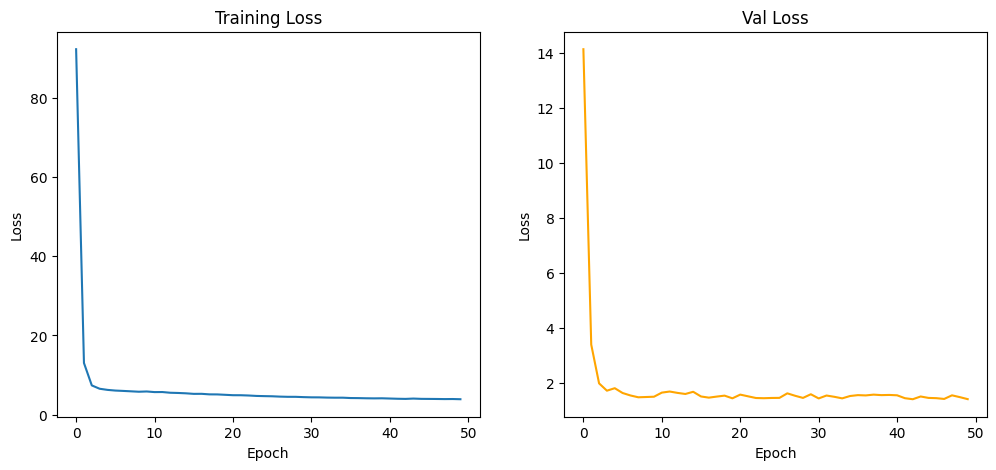

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(train_losses)
ax[0].set_title('Training Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[1].plot(val_losses, color='orange')
ax[1].set_title('Val Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
plt.show()

## 9. Evaluation

In [19]:
val_loss = evaluate(
    model,
    val_loader,
    criterion,
    device
)
test_loss = evaluate(
    model,
    test_loader,
    criterion,
    device
)

print('Evaluation on val/test dataset')
print('Val loss: ', val_loss)
print('Test loss: ', test_loss)

Evaluation on val/test dataset
Val loss:  1.4275145957333397
Test loss:  1.2318725538737607


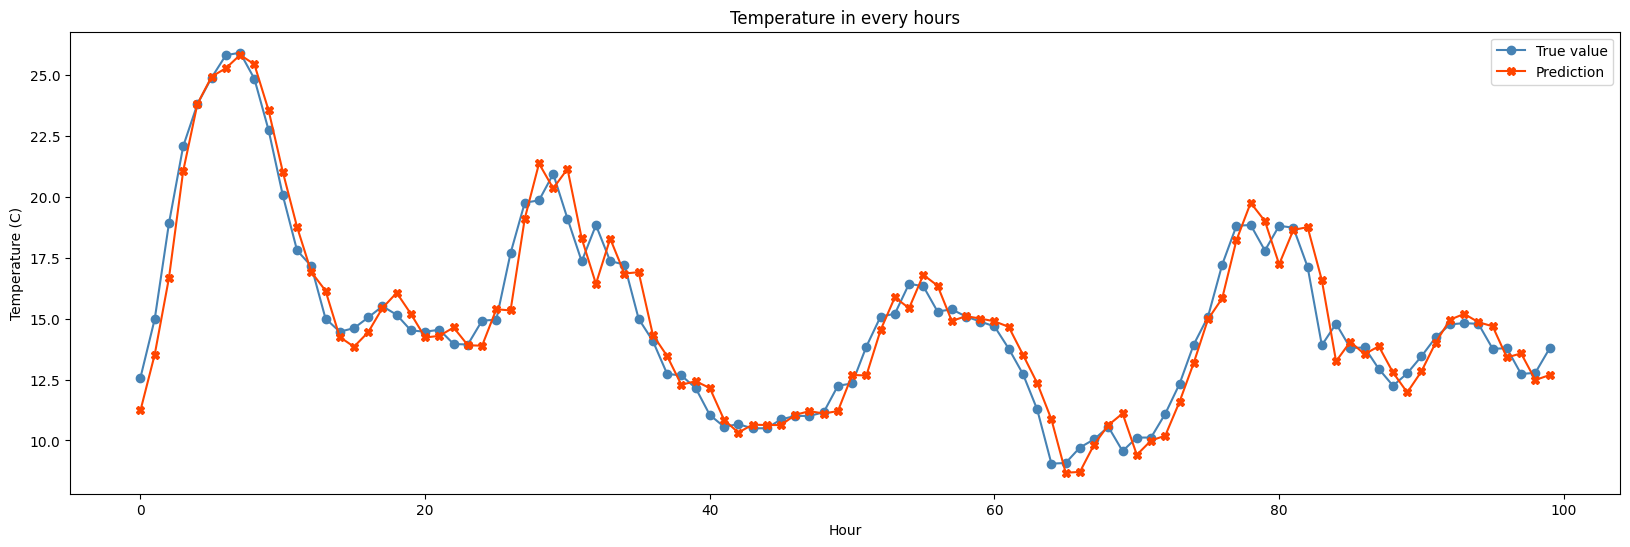

In [20]:
def plot_difference(y, pred):
    plt.figure(figsize=(20, 6))
    times = range(len(y))
    y_to_plot = y.flatten()
    pred_to_plot = pred.flatten()

    plt.plot(times, y_to_plot, color='steelblue', marker='o', label='True value')
    plt.plot(times, pred_to_plot, color='orangered', marker='X', label='Prediction')

    plt.title('Temperature in every hours')
    plt.xlabel('Hour')
    plt.ylabel('Temperature (C)')
    plt.legend()
    plt.show()

inputs = torch.tensor(X_test[:100], dtype=torch.float32).to(device)
model.eval()
with torch.no_grad():
    outputs = model(inputs).detach().cpu().numpy()
plot_difference(y_test[:100], outputs)